# Защита персональных данных клиентов

## **Описание проекта**

### Постановка задачи

Требуется  защитить данные клиентов страховой компании «Хоть потоп». Для чего требуется разработать метод преобразования данных, удовлетворяющий следующим условиям:
- сложность восстановления персональной информации;
- корректность его работы;
- качество моделей машинного обучения, оцененное по метрике R2, на преобразованных данных не ухудшится.

### Описание данных

**Признаки:** пол, возраст и зарплата застрахованного, количество членов его семьи.<br />
**Целевой признак:** количество страховых выплат клиенту за последние 5 лет.

## **Подготовительные работы**

### Импорт библиотек

In [1]:
#!pip install -U scikit-learn
#!pip install imbalanced-learn

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression  #
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

%matplotlib notebook
%matplotlib inline

In [2]:
# Отключение warning
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
#Формат float
pd.options.display.float_format = '{:,.2f}'.format
# Сброс ограничений на число столбцов
pd.options.display.max_columns = None


### Информация о столбцах:

In [3]:
data_name = 'Данные о клиентах'
data_fields = {
    'Пол':['Пол', False],
    'Возраст':['Возраст', True],
    'Зарплата':['Зарплата', True],
    'Члены семьи':['Члены семьи', True],
    'Страховые выплаты':['Страховые выплаты', True]
}


### Функция получения информации о столбце

In [4]:
def col_reaper(ddf,param_name,plot_hist = True):
    global data_fields
    data_len = len(ddf)
    param = ddf[param_name]
    
    #Определение имени столбца
    if data_fields.get(param_name)[0] is not None:
        field = data_fields.get(param_name)[0]
    else:
        field = ''
        
    #Описание данных
    print('')
    print('\033[4m'+'Описание данных:'+ '\033[0m')
    print(param.describe(datetime_is_numeric=True))
    typer = type(param[0])
    print('\033[4m' +  'Количество записей:' + '\033[0m', sum(param.notna()), 'из', data_len)
    if sum(param.isna()) >0:
       print('\033[4m' +  'Пропущено:' + '\033[0m', sum(param.isna()))
       print('')

    #Построение гистограммы
    print('\033[4m'+'\nТип:\n' + '\033[0m', typer)
#    if plot_hist and not 'str' in str(typer):
#        print('\nГистограмма значений:')
#        param.hist();
    if plot_hist and not 'str' in str(typer):
            print('\033[4m'+'\nГистограмма значений:'+ '\033[0m')
            param.plot(kind='hist',bins=20,figsize=(12,5), grid = True)
            plt.title(field)
            #plt.xlabel('Населенные пункты') 
            plt.ylabel('Количество записей')
            plt.xticks(rotation=0)
            plt.show()
            
    else:
        if len(param.unique())<=40:
            #param_index = param.reset_index()
            print('\033[4m'+'\nРаспределение уникальных значений (первые 10 значений в порядке убывания):'+ '\033[0m')
            param_group=ddf.groupby(param_name).agg(cnt=(param_name,'count')).reset_index()
            display(param_group.sort_values(by='cnt',ascending=False).reset_index(drop=True).head(10))
            
            print('\033[4m'+'\nГистограмма значений:'+ '\033[0m')
            param_group.plot(x=param_name, y='cnt', kind='bar',figsize=(12,5))
            plt.title(field)
            plt.xlabel('') 
            plt.ylabel('Количество записей')
            if len(param.unique())<=20:
                plt.xticks(rotation=0)
            else:
                plt.xticks(rotation=90)
            plt.show()
    print('')
    

### Функция получения информации о датафрейме

In [5]:
def df_reaper(df, df_name ='', data_fields = {}):
    #global data_fields
    #global df_name
    #global descript
    
    # Список столюцов для гистограмм, диаграмм, корелляции и т.п.
    cols = df.columns
    #print(data_fields)
    true_cols = []
    for col in cols:
        #print(col,data_fields.get(col))
        if data_fields.get(col)[1]:
            true_cols.append(col)

    print('\033[1;4m' +  df_name + '\033[0m \n')   
    print('\033[1m' +  'Количество записей:' + '\033[0m')   
    df_len = len(df)
    display(df_len)
    print('')
    
    print('\033[1m' +  'Первые 5 строк данных:' + '\033[0m')   
    display(df.head())
    print('')
    
    print('\033[1m' +  'Информация о датафрейме:' + '\033[0m')
    print('')
    display(df.info())
    
    print('\033[1m' +  'Дубликаты:' + '\033[0m')
    if df.duplicated().sum() > 0:
        print ('Обнаружено дубликатов', df.duplicated().sum())
    else:    
        print ('Дубликатов не обнаружено')
    print('')
    
    print('\033[1m' +  'Описание данных в столбцах с числовыми значениями:' + '\033[0m')
    #display(describer(df[true_cols]))
    display(df.describe().T)

    print('\033[1m' +  'Диаграмма рассеивания:' + '\033[0m')
    pd.plotting.scatter_matrix(df[true_cols], figsize=(16, 16)); 
    plt.show()
    
    print('\033[1m' +  'Корелляция данных:' + '\033[0m')
#    display(df[true_cols].corr())
    
    plt.figure(figsize=(16, 6))
    # define the mask to set the values in the upper triangle to True
    mask = np.triu(np.ones_like(df[true_cols].corr(), dtype=np.bool))
    heatmap = sns.heatmap(df[true_cols].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    #heatmap.set_title('Корелляция данных', fontdict={'fontsize':18}, pad=16);
    plt.show()
    
    print('\033[1m' +  'Столбцы:' + '\033[0m \n')
 #   cols = df.columns

    for col in cols:
        if data_fields.get(col)[0] is not None:
            field = data_fields.get(col)[0]
        else:
            field = ''
        print('\033[1;3m' +  col + ' - ' + field + '\033[0m')
        plot_hist = data_fields.get(col)[1]
        col_reaper(df,col,plot_hist)

## **Загрузка данных**

In [6]:
try:
    data = pd.read_csv('datasets/insurance.csv')
except:
    data = pd.read_csv('/datasets/insurance.csv')

### Анализ датасета

 

Количество записей:


5000


Первые 5 строк данных:


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.00,"49,600.00",1,0
1,0,46.00,"38,000.00",1,1
2,0,29.00,"21,000.00",0,0
3,0,21.00,"41,700.00",2,0
4,1,28.00,"26,100.00",0,0



Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


None

Дубликаты:
Обнаружено дубликатов 153

Описание данных в столбцах с числовыми значениями:


,count,mean,std,min,25%,50%,75%,max
Пол,"5,000.00",0.50,0.50,0.00,0.00,0.00,1.00,1.00
Возраст,"5,000.00",30.95,8.44,18.00,24.00,30.00,37.00,65.00
Зарплата,"5,000.00","39,916.36","9,900.08","5,300.00","33,300.00","40,200.00","46,600.00","79,000.00"
Члены семьи,"5,000.00",1.19,1.09,0.00,0.00,1.00,2.00,6.00
Страховые выплаты,"5,000.00",0.15,0.46,0.00,0.00,0.00,0.00,5.00


Диаграмма рассеивания:


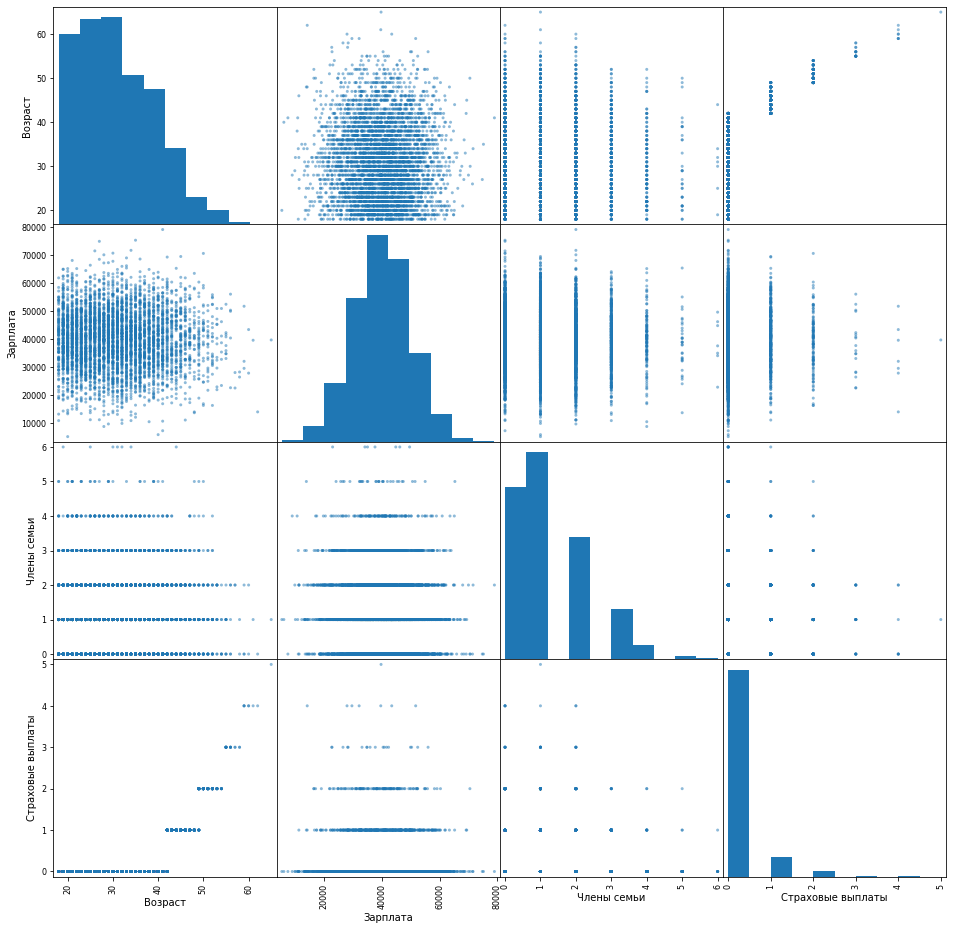

Корелляция данных:


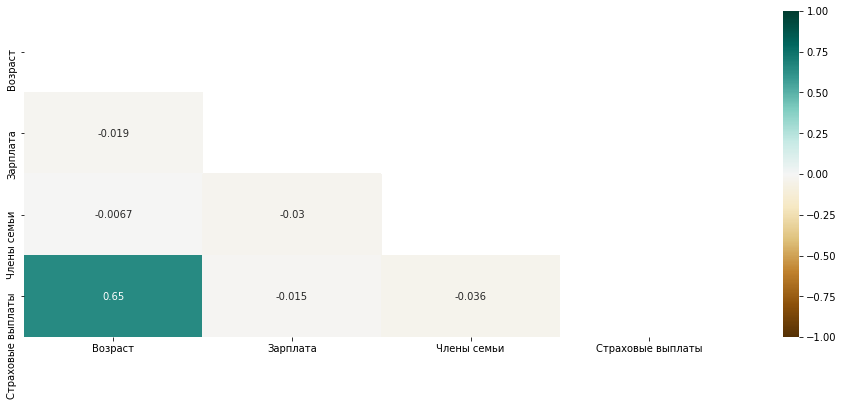

Столбцы: 

Пол - Пол

Описание данных:
count   5,000.00
mean        0.50
std         0.50
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: Пол, dtype: float64
Количество записей: 5000 из 5000

Тип:
 <class 'numpy.int64'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,Пол,cnt
0,0,2505
1,1,2495



Гистограмма значений:


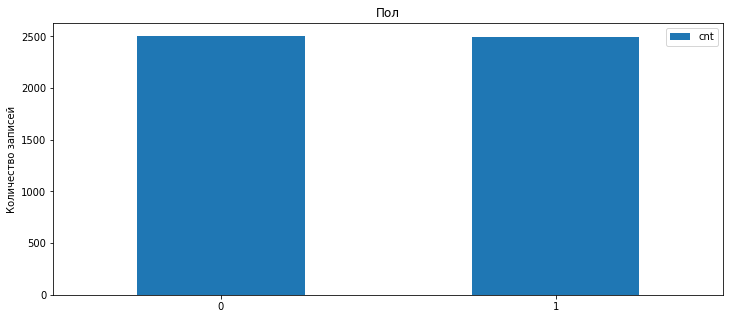


Возраст - Возраст

Описание данных:
count   5,000.00
mean       30.95
std         8.44
min        18.00
25%        24.00
50%        30.00
75%        37.00
max        65.00
Name: Возраст, dtype: float64
Количество записей: 5000 из 5000

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


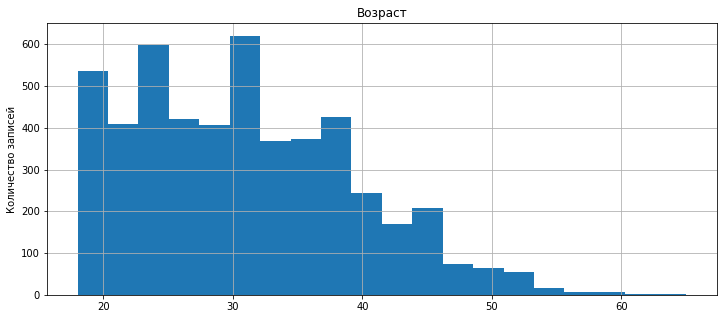


Зарплата - Зарплата

Описание данных:
count    5,000.00
mean    39,916.36
std      9,900.08
min      5,300.00
25%     33,300.00
50%     40,200.00
75%     46,600.00
max     79,000.00
Name: Зарплата, dtype: float64
Количество записей: 5000 из 5000

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


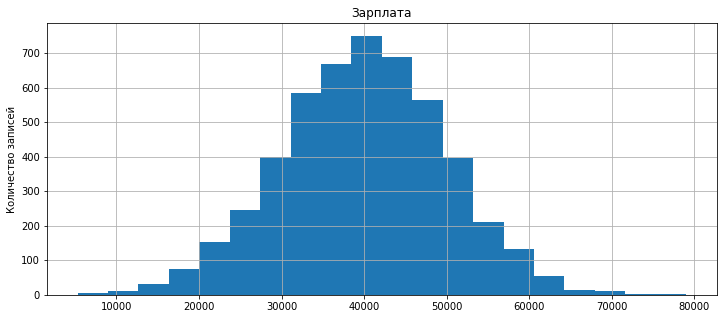


Члены семьи - Члены семьи

Описание данных:
count   5,000.00
mean        1.19
std         1.09
min         0.00
25%         0.00
50%         1.00
75%         2.00
max         6.00
Name: Члены семьи, dtype: float64
Количество записей: 5000 из 5000

Тип:
 <class 'numpy.int64'>

Гистограмма значений:


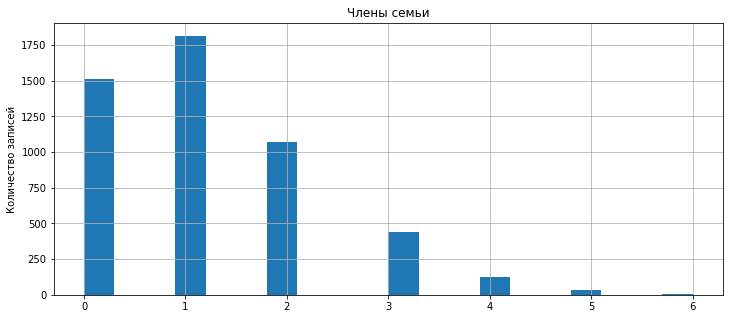


Страховые выплаты - Страховые выплаты

Описание данных:
count   5,000.00
mean        0.15
std         0.46
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         5.00
Name: Страховые выплаты, dtype: float64
Количество записей: 5000 из 5000

Тип:
 <class 'numpy.int64'>

Гистограмма значений:


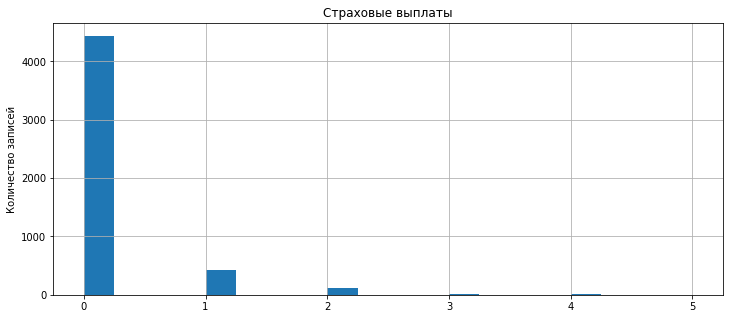

In [7]:
df_reaper(data, '', data_fields)

In [8]:
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.00,"49,600.00",1,0
1,0,46.00,"38,000.00",1,1
2,0,29.00,"21,000.00",0,0
3,0,21.00,"41,700.00",2,0
4,1,28.00,"26,100.00",0,0


### Подготовка данных

#### Дубликаты

Данные содержат дубликаты 153 записей.

Поскольку данные неименованные, а число признаков невелико, существует достаточно большая вероятность совпадений записей о разных клиентах.
Поэтому удаление дубликатов не требуется.

In [9]:
data[data.duplicated(keep = False)].head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
3,0,21.00,"41,700.00",2,0
24,0,21.00,"40,400.00",3,0
52,1,29.00,"42,400.00",0,0
59,1,30.00,"49,900.00",1,0
63,0,32.00,"43,800.00",1,0


#### Разделение признаков

Целевой признак - **Страховые выплаты**

In [10]:
target = data['Страховые выплаты'] 
features = data.drop('Страховые выплаты', axis=1)

In [11]:
features

,Пол,Возраст,Зарплата,Члены семьи
0,1,41.00,"49,600.00",1
1,0,46.00,"38,000.00",1
2,0,29.00,"21,000.00",0
3,0,21.00,"41,700.00",2
4,1,28.00,"26,100.00",0
...,...,...,...,...
4995,0,28.00,"35,700.00",2
4996,0,34.00,"52,400.00",1
4997,0,20.00,"33,900.00",2
4998,1,22.00,"32,700.00",3


Числовые и категориальные признаки:

In [12]:
numeric = ['Возраст', 'Зарплата']
categorial = ['Пол', 'Члены семьи']

#### Разбивка датасета  на тренировочную и валидационную и тестовую выборку в пропорции 75:25

In [13]:
target.value_counts()

0    4436
1     423
2     115
3      18
4       7
5       1
Name: Страховые выплаты, dtype: int64

In [14]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Из-за редкости некоторых значений стратификация при разбивке невозможна :(

#### Прямое кодирование

Столбец "Пол" не требует прямого кодирования: он уже бинарен. Применим прямое кодирование для столбца: "Члены семьи"

In [15]:
ohe_columns=['Члены семьи']
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
encoder_ohe.fit(features_train[ohe_columns])

OneHotEncoder(drop='first', sparse=False, sparse_output=False)

In [16]:
try:
    new_columns = encoder_ohe.get_feature_names_out()
    new_columns
except:
    new_columns = encoder_ohe.get_feature_names()
    new_columns
    

In [17]:
features_train[new_columns] = encoder_ohe.transform(features_train[ohe_columns])
features_train = features_train.drop(ohe_columns, axis=1)

In [18]:
features_valid[new_columns] = encoder_ohe.transform(features_valid[ohe_columns])
features_valid = features_valid.drop(ohe_columns, axis=1)

In [19]:
features_train

,Пол,Возраст,Зарплата,Члены семьи_1,Члены семьи_2,Члены семьи_3,Члены семьи_4,Члены семьи_5,Члены семьи_6
3369,1,43.00,"36,200.00",1.00,0.00,0.00,0.00,0.00,0.00
1441,1,34.00,"57,600.00",0.00,0.00,0.00,0.00,0.00,0.00
571,0,32.00,"41,100.00",1.00,0.00,0.00,0.00,0.00,0.00
225,0,36.00,"45,100.00",1.00,0.00,0.00,0.00,0.00,0.00
2558,0,33.00,"50,600.00",0.00,1.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...
3497,0,42.00,"32,100.00",0.00,0.00,0.00,0.00,0.00,0.00
3492,0,28.00,"22,700.00",0.00,0.00,0.00,1.00,0.00,0.00
2177,1,41.00,"44,700.00",1.00,0.00,0.00,0.00,0.00,0.00
3557,0,22.00,"50,100.00",0.00,0.00,0.00,1.00,0.00,0.00


#### Масштабирование целевых признаков

Масштабирование числовых признаков:
1. Уберет дисбаланс значений параметров
2. Дополнительно защитит персональные данные

In [20]:
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [21]:
features_train.head()

,Пол,Возраст,Зарплата,Члены семьи_1,Члены семьи_2,Члены семьи_3,Члены семьи_4,Члены семьи_5,Члены семьи_6
3369,1,1.41,-0.38,1.00,0.00,0.00,0.00,0.00,0.00
1441,1,0.35,1.79,0.00,0.00,0.00,0.00,0.00,0.00
571,0,0.11,0.12,1.00,0.00,0.00,0.00,0.00,0.00
225,0,0.59,0.52,1.00,0.00,0.00,0.00,0.00,0.00
2558,0,0.23,1.08,0.00,1.00,0.00,0.00,0.00,0.00


#### Обучение модели

In [22]:
model_0 = LinearRegression()
model_0.fit(features_train, target_train)

LinearRegression()

Метрика R2:

In [23]:
print('Метрика R2 модели: {:.2f}'.format(model_0.score(features_train, target_train)))

Метрика R2 модели: 0.42


### Итог этапа:

**Анализ датасета**<br />
1. Исходный набор данных содержит 5000 записей о клиентах страховой компании.
2. Данные содержат 153 дубликата, не требующих удаления
3. Данные полны, не имеют выбросов
4. Существует корелляция 0.65 между возрастом и количеством страховых случаев

**Подготовка данных**<br />
1. Произведено разделение датасета на тренировочную и валидационную выборку в пропорции 3:1
2. Произведено масштабирование числовых признаков
3. Произведено прямое кодирование категориальных признаков

**Обучение модели**<br />
1. На подготовленной обучающей выборке обучена модель LinearRegression
2. Метрика R2 модели на обучающей выборке: 0.42

## **Умножение матриц**

### Постановка задачи: ###

 Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

- $w'$ — вектор весов линейной регрессии матрицы, полученной умножением матрицы признаков на обратимую матрицу (нулевой элемент равен сдвигу) (нулевой элемент равен сдвигу)
- $a$ — предсказания по матрице признаков
- $a'$ — предсказания по матрице признаков, умноженной на обратимую матрицу

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

### Ответ: ###
Не изменится<br /><br />

### Обоснование: ###

Если $P$ - обратимая матрица, то предсказания, сделанные при умножении признаков на нее:
$$
a'= XPw'
$$
где 
$$
w' = ((XP)^T XP)^{-1} (XP)^T y
$$

То есть, необходимо доказать, что 
$$ 
a = a'
$$

Преобразуем формулу обучения для матрицы, полученной умножением матрицы признаков на обратимую матрицу

$$
w' = ((XP)^T XP)^{-1} (XP)^T y
$$

$$
w' = (P^T X^T X P)^{-1}) P^T X^T y
$$

$$
w' = (P^T (X^T X) P)^{-1}) P^T X^T y
$$

$$
w' = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y
$$

$$
w' = P^{-1} (X^T X)^{-1} X^T y
$$

$$
w' = P^{-1} w
$$

Тогда:
$$
a' = XPw'= XPP^{-1} w = Xw
$$

$$
a' = a
$$

Что и требовалось доказать.

### Итог этапа:

 Доказано, что при создании признаков путем умножения их на обратимую матрицу и обучению по формуле линейной регрессии, предсказания модели не изменятся, а следовательно, не изменятся и значения любых метрик, оценивающих эту модель, по сравнению с исходной моделью.

## **Алгоритм преобразования**

### Алгоритм
1. Сгенерировать случайную квадратную матрицу размерностью, равной количеству признаков
2. Проверить ее обратимость
3. Если матрица необратима - вернуться на шаг 1
4. Умножить признаки на полученную матрицу
5. Обучить модель линейной регрессии на новых признаках.

### Обоснование
В предыдущем разделе было доказано, что при создании признаков путем умножения их на обратимую матрицу и обучению по формуле линейной регрессии, предсказания модели не изменятся, а следовательно, не изменятся и значения любых метрик, оценивающих эту модель, по сравнению с исходной моделью.

### Реализация алгоритма

#### Создание обратимой матрицы-ключа:

In [24]:
matrix_size = features_train.shape[1]
matrix_size

9

In [25]:
det = 0 #Детерминант матрицы
while det ==0:
    key_matrix = np.random.randn(matrix_size,matrix_size)
    det = np.linalg.det(key_matrix)
key_matrix

array([[ 0.29905159, -0.45852233, -0.37826149,  0.17955956,  0.37070572,
        -0.97962329, -2.46892022, -2.4682745 ,  1.14858342],
       [-0.45378845,  0.02010792,  0.17281752,  0.28474913, -0.64722789,
        -0.71887507,  0.25523283, -0.71845215,  2.55819589],
       [ 1.51124808, -0.27253162,  0.11425607,  0.14547941, -0.81606232,
        -0.26270928,  1.0452632 , -1.22839446, -0.48072707],
       [-1.11721606,  0.14146166,  0.0955802 ,  0.03162739,  2.60041321,
        -0.9749286 , -0.85592835,  0.42248756,  0.77640414],
       [-0.31976956,  0.07009759,  0.28212255,  0.31317474, -0.49604768,
         0.80776567,  1.93578559,  0.80544092,  1.41888269],
       [ 0.22882287, -0.52710965,  0.11323121,  0.87349632,  1.86414945,
        -0.43854336,  0.57548879, -0.49861662, -0.7421638 ],
       [-0.42854697,  0.33574202, -1.17867897,  0.6295036 , -0.06752925,
         0.95940547,  1.15561496, -1.44960164,  0.19920334],
       [-0.33271129, -1.35235063,  0.72867818, -1.58548194, -0

#### Умножение признаков на матрицу-ключ:

In [26]:
features_train.head()

,Пол,Возраст,Зарплата,Члены семьи_1,Члены семьи_2,Члены семьи_3,Члены семьи_4,Члены семьи_5,Члены семьи_6
3369,1,1.41,-0.38,1.00,0.00,0.00,0.00,0.00,0.00
1441,1,0.35,1.79,0.00,0.00,0.00,0.00,0.00,0.00
571,0,0.11,0.12,1.00,0.00,0.00,0.00,0.00,0.00
225,0,0.59,0.52,1.00,0.00,0.00,0.00,0.00,0.00
2558,0,0.23,1.08,0.00,1.00,0.00,0.00,0.00,0.00


In [27]:
features_valid.head()

,Пол,Возраст,Зарплата,Члены семьи_1,Члены семьи_2,Члены семьи_3,Члены семьи_4,Члены семьи_5,Члены семьи_6
3183,0,0.23,-0.09,0.00,0.00,0.00,1.00,0.00,0.00
1071,0,2.24,0.32,0.00,1.00,0.00,0.00,0.00,0.00
2640,1,0.94,0.22,0.00,0.00,0.00,0.00,0.00,0.00
2282,0,-1.31,-0.52,0.00,0.00,0.00,0.00,0.00,0.00
1595,0,1.18,0.01,0.00,0.00,0.00,1.00,0.00,0.00


In [28]:
features_matrix_train = features_train.dot(key_matrix)
features_matrix_valid =  features_valid.dot(key_matrix)

In [29]:
features_matrix_train.head()

,0,1,2,3,4,5,6,7,8
3369,-2.03,-0.19,-0.08,0.56,2.36,-2.87,-3.36,-2.60,5.72
1441,2.84,-0.94,-0.11,0.54,-1.32,-1.70,-0.51,-4.92,1.18
571,-0.99,0.11,0.13,0.08,2.43,-1.09,-0.70,0.20,1.01
225,-0.59,0.01,0.26,0.27,1.79,-1.53,-0.16,-0.64,2.02
2558,1.21,-0.22,0.45,0.54,-1.53,0.36,3.12,-0.69,1.49


In [30]:
features_matrix_valid.head()

,0,1,2,3,4,5,6,7,8
3183,-0.68,0.37,-1.15,0.68,-0.14,0.82,1.12,-1.50,0.84
1071,-0.85,0.03,0.71,1.00,-2.21,-0.89,2.84,-1.20,7.00
2640,0.20,-0.50,-0.19,0.48,-0.42,-1.71,-2.00,-3.41,3.45
2282,-0.19,0.12,-0.29,-0.45,1.27,1.08,-0.88,1.58,-3.09
1595,-0.95,0.36,-0.97,0.97,-0.84,0.11,1.46,-2.30,3.21


#### Обучение модели

In [31]:
model_1 = LinearRegression()
model_1.fit(features_matrix_train, target_train)

LinearRegression()

#### Метрика R2: ####

In [32]:
score_0 = model_0.score(features_train, target_train)
print('Метрика R2 исходной модели: {:.2f}'.format(score_0))

Метрика R2 исходной модели: 0.42


In [33]:
score_1 = model_1.score(features_matrix_train, target_train)
print('Метрика R2 модели на основе измененных данных: {:.2f}'.format(score_1))

Метрика R2 модели на основе измененных данных: 0.42


In [34]:
print('Различие в оценке:{:.2e} '.format(abs(score_1-score_0)))

Различие в оценке:1.11e-16 


Значения метрик практически совпадают

### Итог этапа:

1. Описан алгоритм
2. Создана обратимая матрицы-ключ
3. Признаки закодированы их умножением на матрицу-ключ
4. Обучена модель LinearRegression
5. Метрики R2 для полученной и исходной моделей на обучающей выборке практически совпадают

## **Проверка алгоритма**

### Проверка алгоритма на валидационных данных:

In [35]:
score_0 = model_0.score(features_valid, target_valid)
score_0

0.43508174579902115

In [36]:
score_1 = model_1.score(features_matrix_valid, target_valid)
score_1

0.43508174579902115

In [37]:
print('Различие в оценке:{:.2e} '.format(abs(score_1-score_0)))

Различие в оценке:0.00e+00 


Значения метрик совпадают

### Восстановление данных

In [38]:
features_back_train = features_matrix_train.dot(np.linalg.inv(key_matrix))
features_back_train.columns = features_train.columns
features_back_train.head()

,Пол,Возраст,Зарплата,Члены семьи_1,Члены семьи_2,Члены семьи_3,Члены семьи_4,Члены семьи_5,Члены семьи_6
3369,1.00,1.41,-0.38,1.00,-0.00,-0.00,0.00,0.00,0.00
1441,1.00,0.35,1.79,-0.00,-0.00,0.00,-0.00,-0.00,0.00
571,0.00,0.11,0.12,1.00,-0.00,-0.00,0.00,0.00,0.00
225,-0.00,0.59,0.52,1.00,-0.00,-0.00,0.00,0.00,0.00
2558,0.00,0.23,1.08,-0.00,1.00,0.00,-0.00,-0.00,0.00


Данные восстановлены

### Итог этапа:

1. Метрики R2 для полученной и исходной моделей на валидационной выборке совпадают
2. При умножении закодированнных признаков на матрицу, обратную матрице-ключу, данные признаков восстанавливаются

## **Итог проекта:** ## 

**Анализ датасета**<br />
1. Исходный набор данных содержит 5000 записей о клиентах страховой компании.
2. Данные содержат 153 дубликата, не требующих удаления
3. Данные полны, не имеют выбросов
4. Существует корелляция 0.65 между возрастом и количеством страховых случаев

**Подготовка данных**<br />
1. Произведено разделение датасета на тренировочную и валидационную выборку в пропорции 3:1
2. Произведено масштабирование числовых признаков
3. Произведено прямое кодирование категориальных признаков

**Обучение модели**<br />
1. На подготовленной обучающей выборке обучена модель LinearRegression
2. Метрика R2 модели на обучающей выборке: 0.42

**Умножение матриц**

 Доказано, что при создании признаков путем умножения их на обратимую матрицу и обучению по формуле линейной регрессии, предсказания модели не изменятся, а следовательно, не изменятся и значения любых метрик, оценивающих эту модель, по сравнению с исходной моделью.

**Алгоритм преобразования**

1. Описан алгоритм
2. Создана обратимая матрицы-ключ
3. Признаки закодированы их умножением на матрицу-ключ
4. Обучена модель LinearRegression
5. Метрики R2 для полученной и исходной моделей на обучающей выборке практически совпадают
6. Метрики R2 для полученной и исходной моделей на валидационной выборке совпадают
7. При умножении закодированнных признаков на матрицу, обратную матрице-ключу, данные признаков восстанавливаются

**Результат**

Для защиты данных клиентов страховой компании «Хоть потоп» рекомендуется использовать следующее их преобразование:<br />
Шаг 1. Масштабирование данных.<br />
Шаг 2. Умножение данных на обратимую матрицу размерностью, равной количеству признаков